In [1]:
from __future__ import absolute_import, print_function
import os
import shutil
import warnings
import numpy as np
import pandas as pd
from keras.preprocessing import image
import matplotlib.path as mplpath

from learning2learn.images import generate_image, generate_random_shape, generate_colors
from learning2learn.util import synthesize_data, load_image_dataset

np.random.seed(0)

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
from sklearn.model_selection import train_test_split

def generate_colors(nb_train=50, nb_test=8, random=False):
    nb_colors = nb_train + nb_test
    nb_bins = np.round(np.power(nb_colors, 1 / 3)) + 1
    vals = np.linspace(0, 0.95, int(nb_bins))
    colors = []
    for r in vals:
        for g in vals:
            for b in vals:
                colors.append([r, g, b])

    colors = sorted(colors, key=lambda x: sum(x))
    colors = np.asarray(colors[-nb_colors:])
    if random:
        colors_train, colors_test = train_test_split(colors, test_size=nb_test, random_state=0)
    else:
        colors_train, colors_test = colors[:nb_train], colors[nb_train:]
    
    return colors_train, colors_test

def generate_textures(nb_train=50, nb_test=8, random=False):
    assert os.path.isdir('../data/textures')
    files = sorted([file for file in os.listdir('../data/textures') if file.endswith('tiff')])
    assert len(files) == 58
    assert nb_train + nb_test == 58
    if random:
        files_train, files_test = train_test_split(files, test_size=nb_test, random_state=0)
    else:
        files_train, files_test = files[:nb_train], files[nb_train:]
    
    return files_train, files_test
    
def generate_dataset_parameters(nb_train=50, nb_test=8, random=False):
    # Generate shapes, which are sets of points for which polygons will
    # be generated
    shapes = [generate_random_shape(0, 500, 0, 500, 100) for _ in range(nb_train+nb_test)]
    # Generate colors, which are 3-D vectors of values between 0-1 (RGB values)
    colors = generate_colors(nb_train, nb_test, random)
    # Generate textures, which come from saved image files
    textures = generate_textures(nb_train, nb_test, random)

    return (shapes[:nb_train], shapes[nb_train:]), colors, textures

In [15]:
shape_sets, color_sets, texture_sets = generate_dataset_parameters(
    nb_train=50, nb_test=8, random=True
)

## Lets build a training set with 50 categories and 15 exemplars per category. We will also build a folder of 'test' images with 8 categories (8 shapes x 8 colors x 8 textures = 512 images) which will be sample from to build the trials

In [16]:
def create_dataset_wrapper(inputs):
    create_dataset(inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5], inputs[6])

def create_dataset(shape_sets, color_sets, texture_sets, nb_exemplars, data_folder, train=True, test=True):
    assert len(shape_sets[0]) == len(color_sets[0]) == len(texture_sets[0])
    assert len(shape_sets[1]) == len(color_sets[1]) == len(texture_sets[1])
    nb_train = len(shape_sets[0])
    nb_test = len(shape_sets[1])
    if train:
        # Create folder where training images will be stored; if exists, remove
#         if os.path.isdir(data_folder):
#             assert 'A dataset already exists at the specified location...'
              #shutil.rmtree(test_folder)
#         os.mkdir(data_folder)
        # Build the training dataset
        print('Building the training dataset...')
        # Synthesize the dataset.
        df, _ = synthesize_data(len(shape_sets[0]), nb_exemplars)
        df.sort_values(by='shape', inplace=True)
        # Create the images
        shapes_seen = []
        for shape_ix, color_ix, texture_ix in zip(df['shape'], df['color'], df['texture']):
            if shape_ix not in shapes_seen:
                count = 0
                shapes_seen.append(shape_ix)
            save_file = os.path.join(
                data_folder,
                'category%0.2i_exemplar%0.2i.png' % (shape_ix, count)
            )
            generate_image(
                shape_sets[0][shape_ix], color_sets[0][color_ix], 
                texture_sets[0][texture_ix], save_file
            )
            count += 1
        # Save the dataset parameters so we know what we're working with
        df.to_csv(os.path.join(data_folder, 'data.csv'))
    
    if test:
        # Create folder where testing images will be stored; if exists, remove
        test_folder = os.path.join(data_folder, 'test/')
#         if os.path.isdir(test_folder):
#             assert 'A test dataset already exists at the specified location...'
#             #shutil.rmtree(test_folder)
#         os.mkdir(test_folder)
        # Build the testing dataset
        print('Building the testing dataset...')
        # Synthesize the dataset
        shapes = []
        colors = []
        textures = []
        for shape_ix in range(nb_test):
            count = 0
            for color_ix in range(nb_test):
                for texture_ix in range(nb_test):
                    save_file = os.path.join(
                        test_folder,
                        'category%0.2i_exemplar%0.2i.png' % (shape_ix+nb_train, count)
                    )
                    generate_image(
                        shape_sets[1][shape_ix], color_sets[1][color_ix], 
                        texture_sets[1][texture_ix], save_file
                    )
                    shapes.append(shape_ix+nb_train)
                    colors.append(color_ix+nb_train)
                    textures.append(texture_ix+nb_train)
                    count += 1
        df = pd.DataFrame()
        df['shape'] = shapes
        df['color'] = colors
        df['texture'] = textures
        # Save the dataset parameters so we know what we're working with
        df.to_csv(os.path.join(test_folder, 'data.csv'))

In [17]:
import multiprocessing as mp

data_folder = '../data/images_generated2/'
sets = [(shape_sets, color_sets, texture_sets, 15, data_folder, True, False),
        (shape_sets, color_sets, texture_sets, 15, data_folder, False, True)]
p = mp.Pool(2)
p.map(create_dataset_wrapper, sets)
p.join()
p.close()

Building the training dataset...
Building the testing dataset...


AssertionError: 

In [46]:
# def create_dataset(shape_sets, color_sets, texture_sets, nb_exemplars, data_folder, train=True, test=True):
#     assert len(shape_sets[0]) == len(color_sets[0]) == len(texture_sets[0])
#     assert len(shape_sets[1]) == len(color_sets[1]) == len(texture_sets[1])
#     if train:
#         # Create folder where training images will be stored; if exists, remove
#         if os.path.isdir(data_folder):
#             warnings.warn('A dataset already exists at the specified location...'
#                           'overwriting.')
#             shutil.rmtree(data_folder)
#         os.mkdir(data_folder)
#         # Build the training dataset
#         print('Building the training dataset...')
#         # Synthesize the dataset.
#         df, _ = synthesize_data(len(shape_sets[0]), nb_exemplars)
#         df.sort_values(by='shape', inplace=True)
#         shapes = [shape_sets[0][i] for i in df['shape']]
#         colors = [color_sets[0][i] for i in df['color']]
#         textures = [texture_sets[0][i] for i in df['texture']]
#         for shape, color, texture, i in \
#             zip(shapes, colors, textures, range(len(shapes))):
#             save_file = os.path.join(
#                 data_folder,
#                 'shape%0.2i_color%0.2i_texture%0.2i.png' %
#                 (df['shape'].loc[i], df['color'].loc[i], df['texture'].loc[i])
#             )
#             generate_image(shape, color, texture, save_file)
#         # Save the dataset parameters so we know what we're working with
#         df.to_csv(os.path.join(data_folder, 'data.csv'))
    
#     if test:
#         # Create folder where testing images will be stored; if exists, remove
#         test_folder = os.path.join(data_folder, 'test/')
#         if os.path.isdir(test_folder):
#             warnings.warn('A test dataset already exists at the specified location...'
#                           'overwriting.')
#             shutil.rmtree(test_folder)
#         os.mkdir(test_folder)
#         # Build the testing dataset
#         print('Building the testing dataset...')
#         for s, shape in enumerate(shape_sets[1]):
#             for c, color in enumerate(color_sets[1]):
#                 for t, texture in enumerate(texture_sets[1]):
#                     save_file = os.path.join(
#                         test_folder,
#                         'shape%0.2i_color%0.2i_texture%0.2i.png' %
#                         (s+50, c+50, t+50)
#                     )
#                     generate_image(shape, color, texture, save_file)

In [47]:
#create_dataset(shape_sets, color_sets, texture_sets, 15, data_folder, train=True, test=False)

Building the training dataset...


In [6]:
#create_dataset(shape_sets, color_sets, texture_sets, 15, data_folder, train=False, test=True)

Building the testing dataset...


## Now let's verify that this all worked

In [102]:
def load_image_dataset(data_folder, nb_categories=None, nb_exemplars=None,
                        target_size=(200, 200)):
    # First load the images
    imgs = []
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
    if nb_categories is None:
        # if these two parameters are 'None' we will not subsample the data.
        # simply load and return the images.
        assert nb_exemplars is None
        return imgs
    # Now load the feature info
    feature_file = os.path.join(data_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)
    # Collect a subset of the data according to {nb_categories, nb_exemplars}
    ix = []
    for cat in range(nb_categories):
        ix_cat = select_subset(df[df['shape'] == cat], nb_exemplars + 1)
        #print(ix_cat)
        #ix_cat = df[df['shape'] == cat].index.tolist()
        #ix_cat = ix_cat[:nb_exemplars+1]
        ix.extend(ix_cat)
    imgs = imgs[ix]
    df = df.iloc[ix]

    return imgs, df['shape'].as_matrix()

In [132]:
nb_categories = 50
nb_exemplars = 14

X, _ = load_image_dataset(data_folder, nb_categories, nb_exemplars, target_size=(200, 200))
print(X.shape)

(750, 200, 200, 3)


In [131]:
# plt.figure()
# plt.imshow(X[1])
# plt.axis('off')
# plt.show()

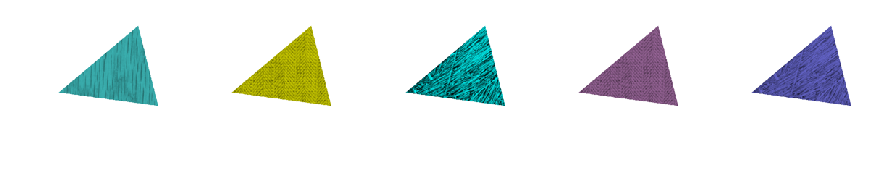

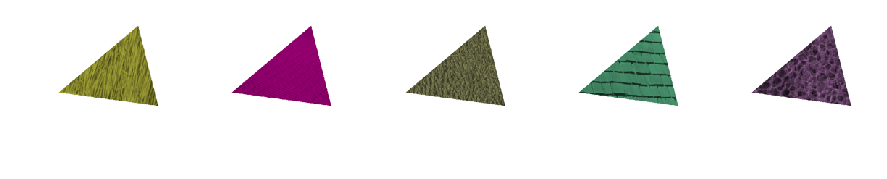

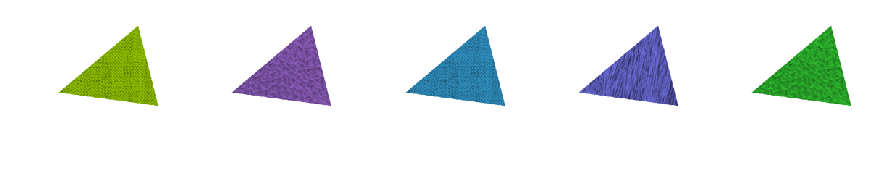

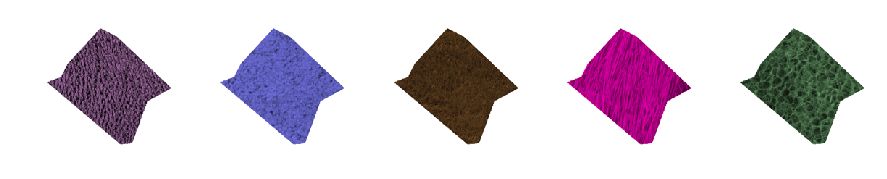

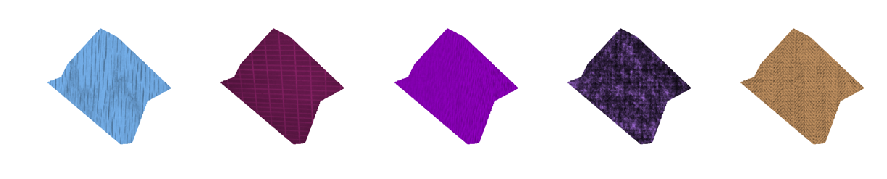

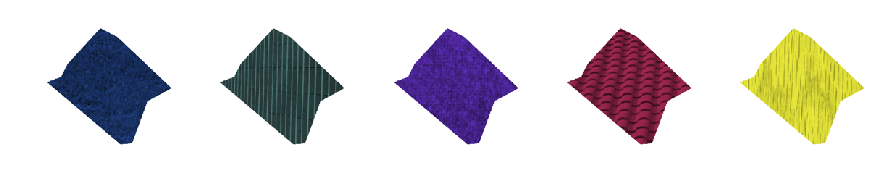

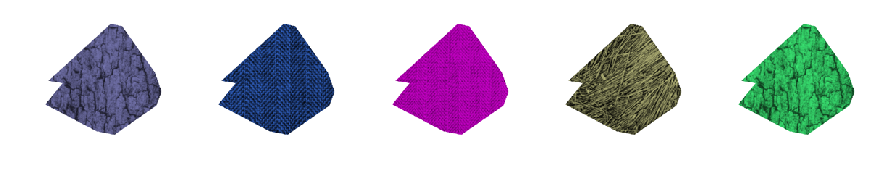

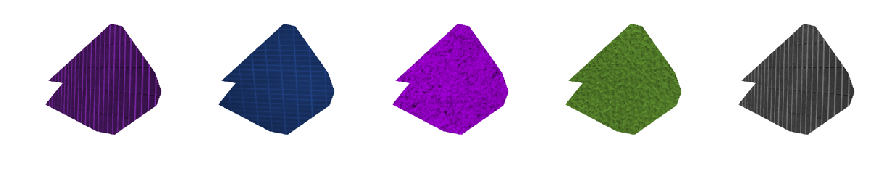

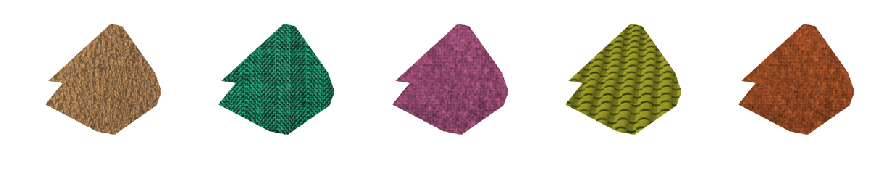

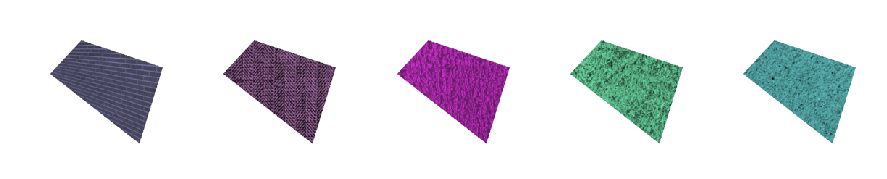

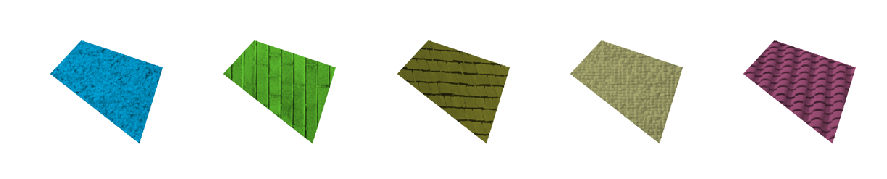

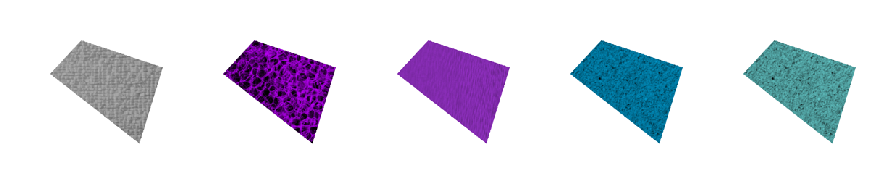

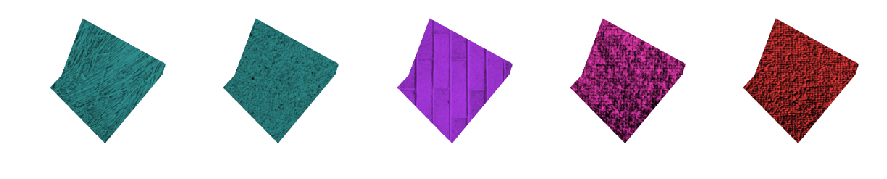

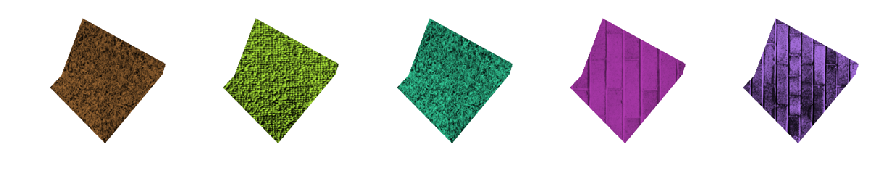

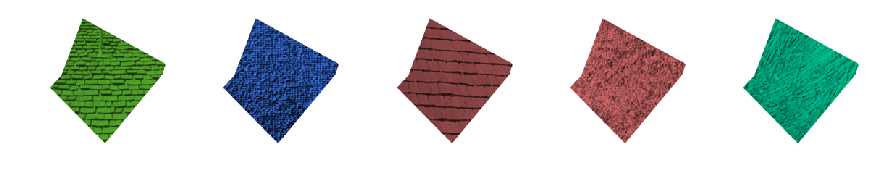

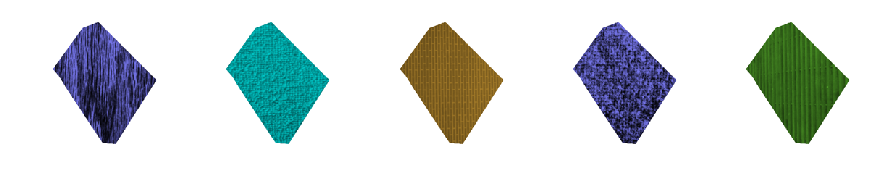

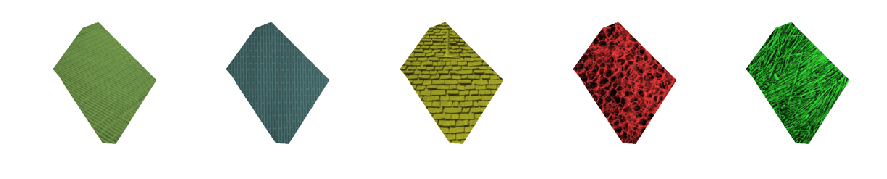

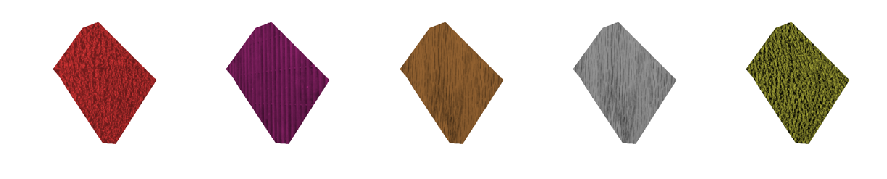

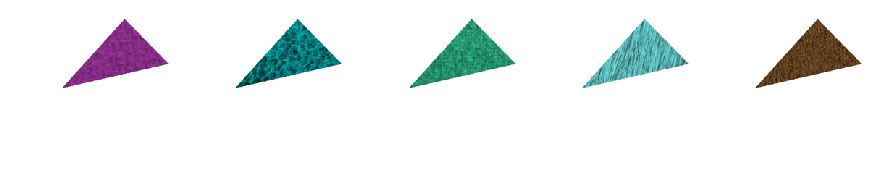

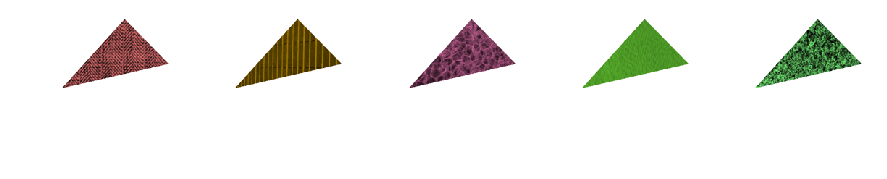

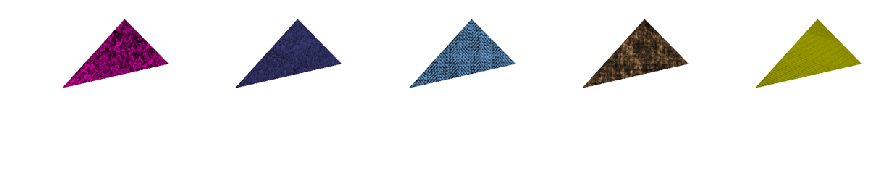

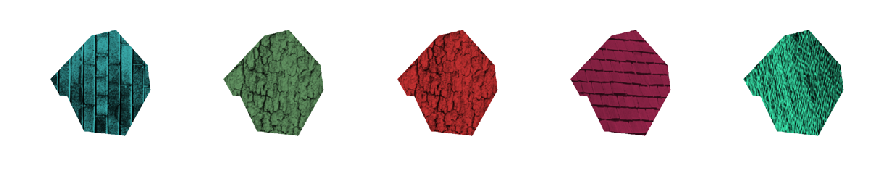

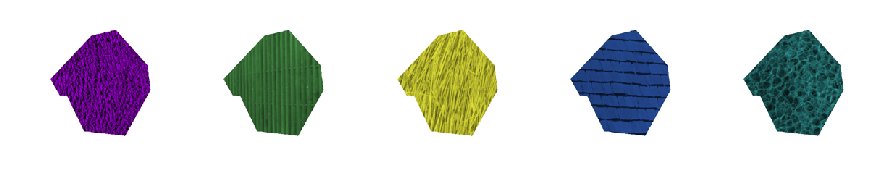

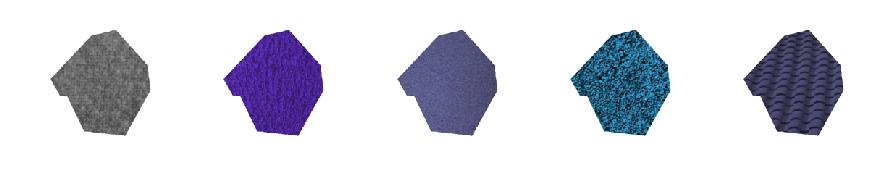

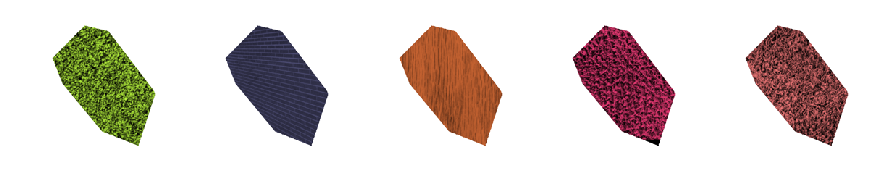

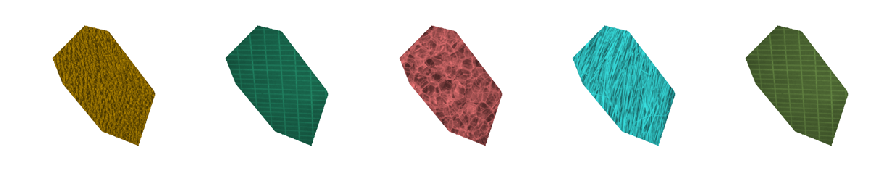

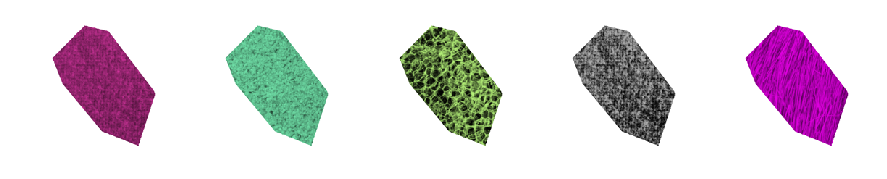

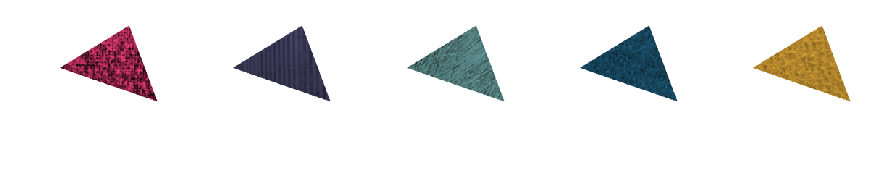

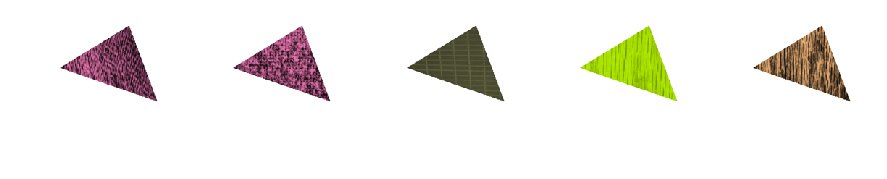

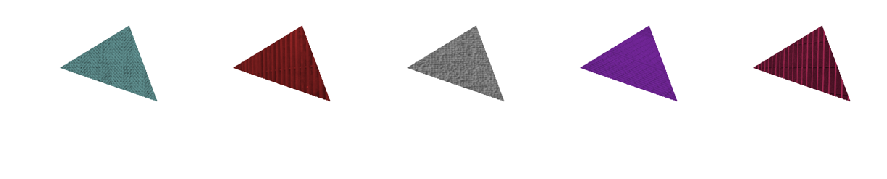

In [134]:
%matplotlib inline
import matplotlib.pylab as plt

for i in range(30):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))
    for j in range(5):
        axes[j].imshow(X[5*i+j])
        axes[j].axis('off')
    plt.show()

# Write function to build trials

In [21]:
def make_trial(shapes, colors, textures):
    # create a random trial
    ix = np.arange(len(shapes))
    
    while True:
        baseline = np.random.choice(ix)
        shape = shapes[baseline]
        color = colors[baseline]
        texture = textures[baseline]
        # only matches in shape
        shape_matches = np.where((shapes == shape) & (colors != color) & (textures != texture))[0]
        # only matches in color
        color_matches = np.where((shapes != shape) & (colors == color) & (textures != texture))[0]
        # only matches in texture
        texture_matches = np.where((shapes != shape) & (colors != color) & (textures == texture))[0]
            
        if len(shape_matches) > 0 and len(color_matches) > 0 and len(texture_matches) > 0:
            break # make sure we have an option for each image...

    shape_match = np.random.choice(shape_matches)
    color_match = np.random.choice(color_matches)
    texture_match = np.random.choice(texture_matches) 

    return [baseline, shape_match, color_match, texture_match]

def build_test_trials(test_folder, nb_trials, target_size=(200, 200)):
    # First, load the images
    imgs = load_image_dataset(test_folder, target_size=target_size)
    # Collect the list of shapes, colors and textures
    files = sorted([file for file in os.listdir(test_folder) if file.endswith('png')])
    shapes = []
    colors = []
    textures = []
    for file in files:
        shape, color, texture = file.split('_')
        shapes.append(int(shape[-2:]))
        colors.append(int(color[-2:]))
        textures.append(int(texture[-6:-4]))
    shapes = np.asarray(shapes)
    colors = np.asarray(colors)
    textures = np.asarray(textures)
    
    # Sample the trials
    ix = []
    for i in range(nb_trials):
        trial = make_trial(shapes, colors, textures)
        print(trial)
        ix.extend(trial)
    ix = np.asarray(ix)
    return imgs[ix]

In [22]:
X_test = build_test_trials(os.path.join(data_folder, 'test/'), 10)

[153, 168, 476, 1]
[334, 343, 463, 502]
[360, 349, 233, 464]
[404, 417, 343, 52]
[330, 383, 140, 418]
[181, 147, 433, 325]
[16, 6, 215, 280]
[84, 121, 403, 460]
[142, 189, 10, 390]
[32, 47, 167, 216]


In [23]:
X_test.shape

(40, 200, 200, 3)

In [28]:
def show_trials(X):
    assert len(X) % 4 == 0
    nb_trials = int(len(X)/4)
    for i in range(nb_trials):
        print('\n')
        # baseline
        plt.figure(figsize=(3,3))
        plt.imshow(X[4*i])
        plt.axis('off')
        plt.show()
        # 3 candidates
        fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10,3))
        axes[0].imshow(X[4*i+1])
        axes[0].axis('off')
        axes[1].imshow(X[4*i+2])
        axes[1].axis('off')
        axes[2].imshow(X[4*i+3])
        axes[2].axis('off')
        plt.show()

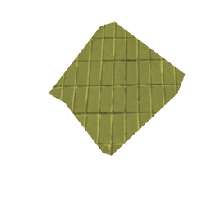

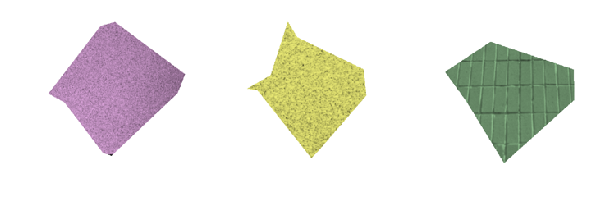

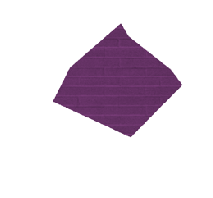

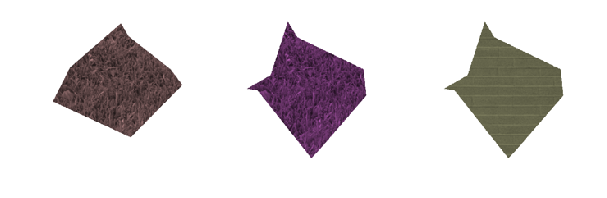

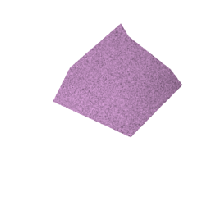

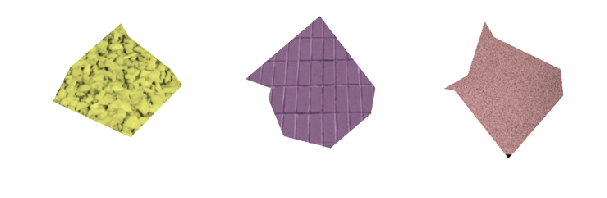

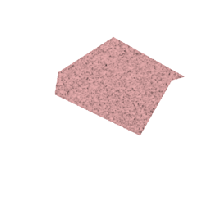

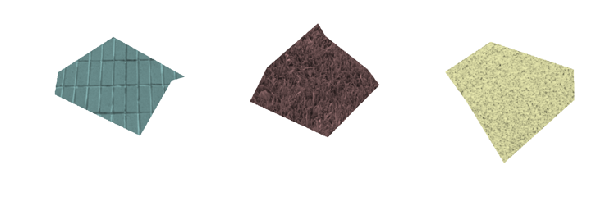

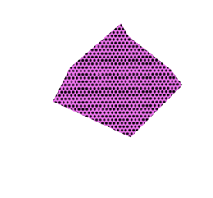

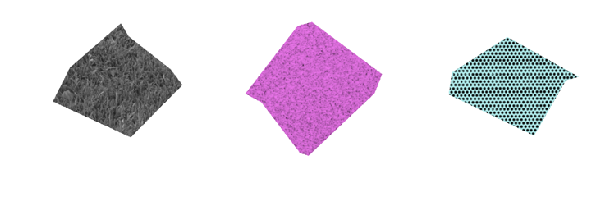

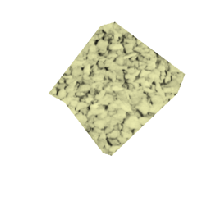

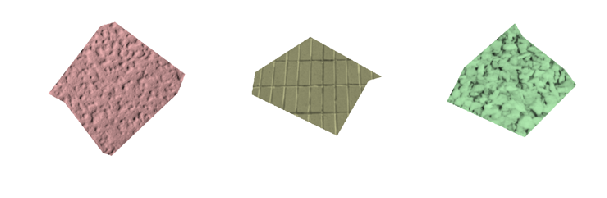

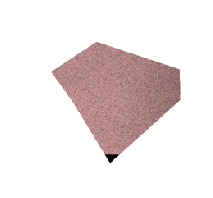

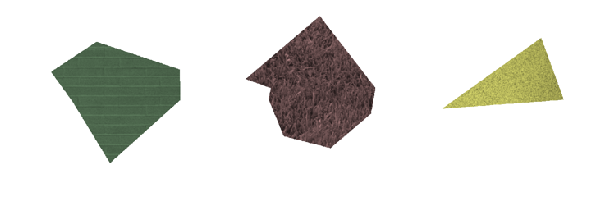

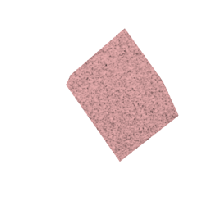

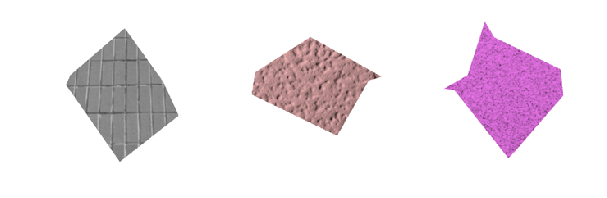

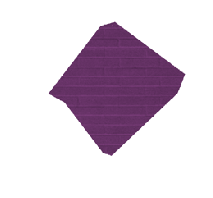

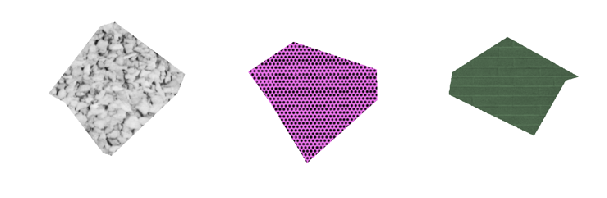

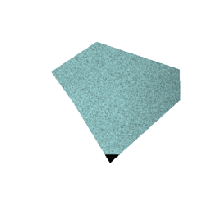

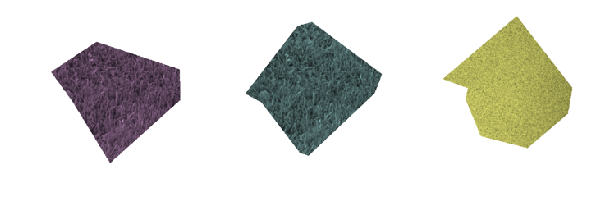

In [29]:
show_trials(X_test)

## Now, lets try updating load_image_dataset so that we get better separation of colors

In [100]:
def select_subset(df, nb_select):
    nb_categories = df.shape[0]
    # Sort by color values, get the indices
    ix = df.sort_values(by='color').index
    step = int(np.ceil(nb_categories/nb_select)) - 1
    
    return [ix[i*step] for i in range(nb_select)]

In [99]:
for i in range(1,15):
    print(select_subset(df[df['shape'] == 0], i))

[2]
[2, 7]
[2, 5, 13]
[2, 6, 10, 0]
[2, 1, 5, 10, 13]
[2, 1, 5, 10, 13, 8]
[2, 1, 5, 10, 13, 8, 4]
[2, 11, 1, 6, 5, 14, 10, 7]
[2, 11, 1, 6, 5, 14, 10, 7, 13]
[2, 11, 1, 6, 5, 14, 10, 7, 13, 0]
[2, 11, 1, 6, 5, 14, 10, 7, 13, 0, 8]
[2, 11, 1, 6, 5, 14, 10, 7, 13, 0, 8, 9]
[2, 11, 1, 6, 5, 14, 10, 7, 13, 0, 8, 9, 4]
[2, 11, 1, 6, 5, 14, 10, 7, 13, 0, 8, 9, 4, 12]


In [87]:
_, df = load_image_dataset(data_folder, 10, 5)

In [104]:
def load_image_dataset(data_folder, nb_categories=None, nb_exemplars=None,
                        target_size=(200, 200)):
    # First load the images
    imgs = []
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
    if nb_categories is None:
        # if these two parameters are 'None' we will not subsample the data.
        # simply load and return the images.
        assert nb_exemplars is None
        return imgs
    # Now load the feature info
    feature_file = os.path.join(data_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)
    # Collect a subset of the data according to {nb_categories, nb_exemplars}
    ix = []
    for cat in range(nb_categories):
        ix_cat = select_subset(df[df['shape'] == cat], nb_exemplars+1)
        #ix_cat = df[df['shape'] == cat].index.tolist()
        #ix_cat = ix_cat[:nb_exemplars+1]
        ix.extend(ix_cat)
    imgs = imgs[ix]
    df = df.iloc[ix]

    return imgs, df

### First try loading the original way

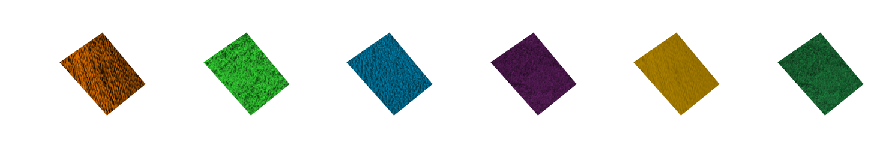

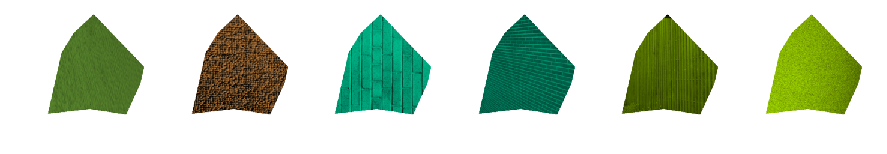

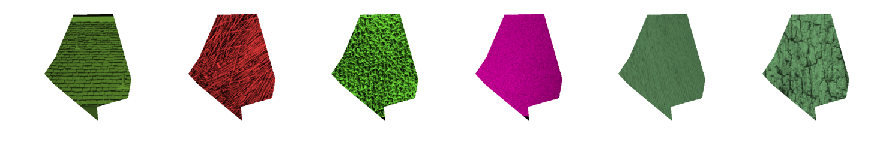

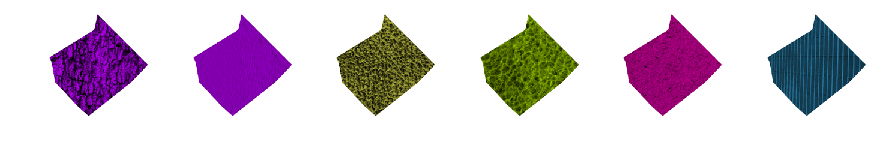

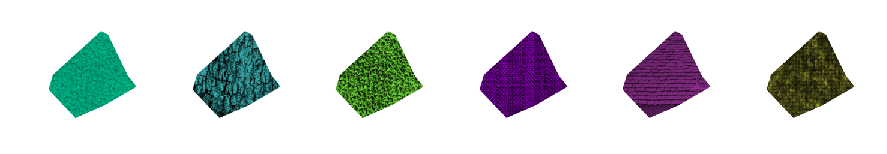

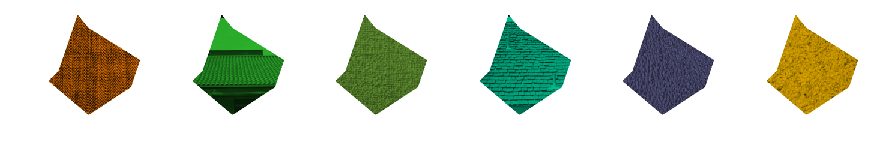

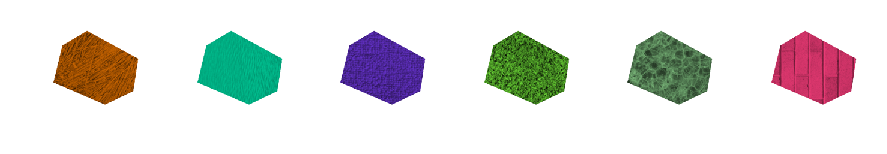

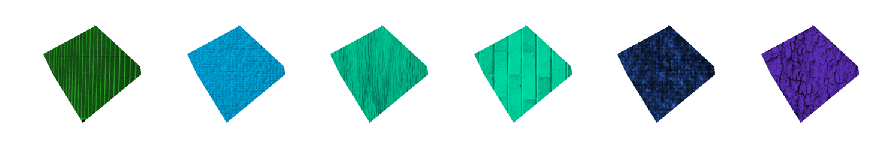

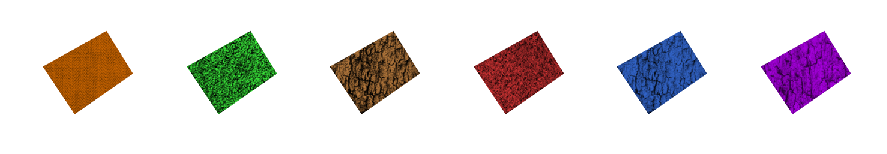

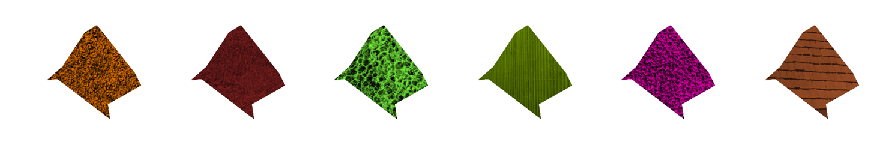

In [103]:
imgs, _ = load_image_dataset(data_folder, 10, 5)

for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,3))
    for j in range(6):
        axes[j].imshow(imgs[i*6+j])
        axes[j].axis('off')
    plt.show()
    print('\n')

### Now try the new way

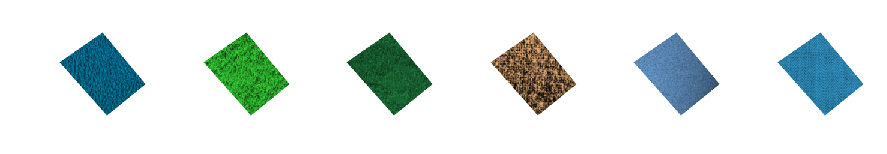

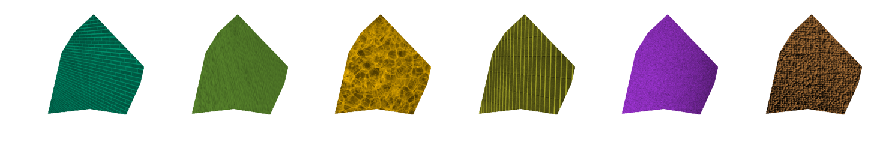

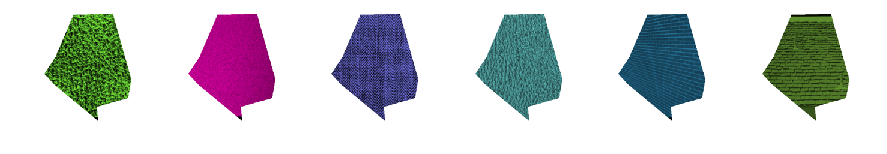

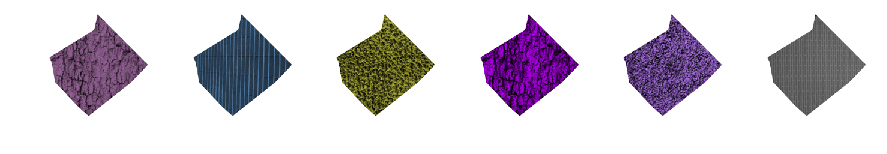

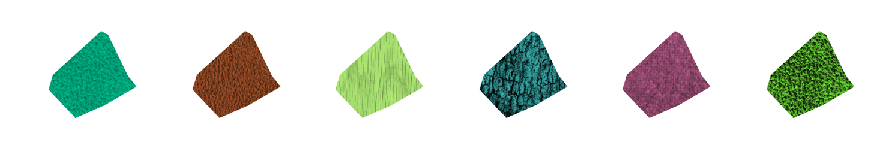

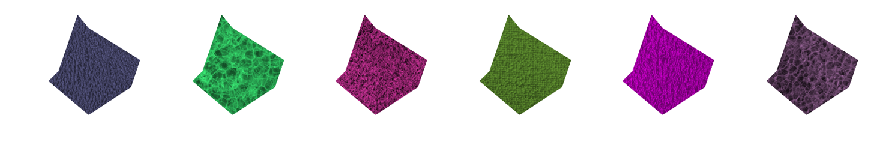

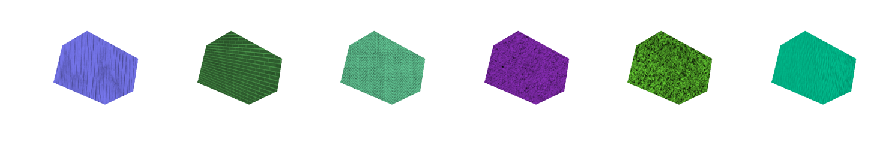

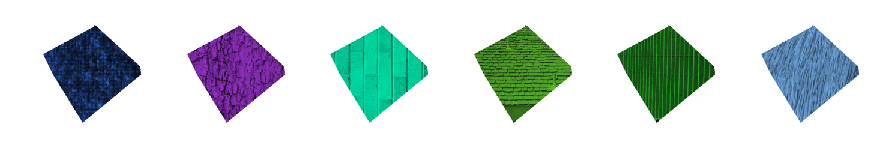

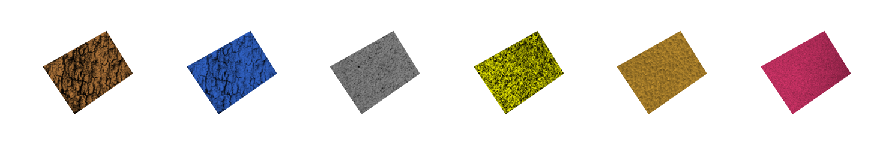

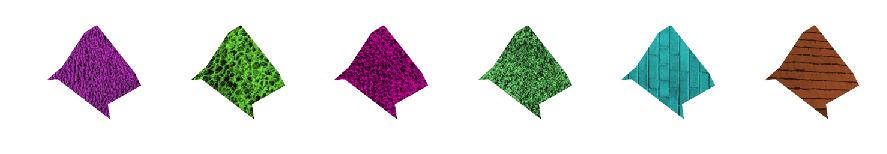

In [105]:
imgs, _ = load_image_dataset(data_folder, 10, 5)

for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,3))
    for j in range(6):
        axes[j].imshow(imgs[i*6+j])
        axes[j].axis('off')
    plt.show()
    print('\n')